In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import json
import os
import requests
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.model_selection import train_test_split
from google.colab import files
from IPython.display import display, HTML, Image

# Device configuration
device = torch.cuda.is_available() and torch.device("cuda") or torch.device("cpu")

# Hyperparameters
NUM_CLASSES = 5
HIDDEN_SIZE = 256
NUM_LAYERS = 3
EMBEDDING_DIM = 128
STROKE_DIM = 3
MAX_SEQ_LEN = 128
BATCH_SIZE = 32
LEARNING_RATE = 0.0005
NUM_EPOCHS = 30
DROPOUT = 0.3
PATIENCE = 7
SAMPLES_PER_CLASS = 100000

CLASSES = ["apple", "square", "triangle", "circle","eye"]

# Download QuickDraw data
def download_quickdraw_data(data_dir="/content/quickdraw_data"):
    os.makedirs(data_dir, exist_ok=True)
    for class_name in CLASSES:
        file_path = os.path.join(data_dir, f"{class_name}.ndjson")
        url = f"https://storage.googleapis.com/quickdraw_dataset/full/simplified/{class_name}.ndjson"
        if not os.path.exists(file_path):
            print(f"Downloading {class_name}.ndjson from {url}...")
            response = requests.get(url, stream=True)
            response.raise_for_status()
            with open(file_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print(f"Downloaded {class_name}.ndjson to {file_path}")
        else:
            print(f"{class_name}.ndjson already exists at {file_path}")

# Dataset Class
class QuickDrawDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        class_idx, strokes = self.data[idx]
        one_hot = torch.zeros(NUM_CLASSES)
        one_hot[class_idx] = 1.0
        strokes = np.array(strokes)
        if len(strokes) > MAX_SEQ_LEN:
            strokes = strokes[:MAX_SEQ_LEN]
        else:
            padding = np.zeros((MAX_SEQ_LEN - len(strokes), STROKE_DIM))
            strokes = np.vstack((strokes, padding))
        return one_hot, torch.tensor(strokes, dtype=torch.float)

# Load QuickDraw data with balancing
def load_quickdraw_data(data_dir="/content/quickdraw_data"):
    data = []
    class_to_idx = {cls: idx for idx, cls in enumerate(CLASSES)}
    class_counts = {cls: 0 for cls in CLASSES}

    for cls in CLASSES:
        file_path = os.path.join(data_dir, f"{cls}.ndjson")
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Expected {cls}.ndjson in {data_dir}, but file not found.")

        with open(file_path, 'r') as f:
            for line in f:
                drawing = json.loads(line)
                if drawing.get("recognized", False) and class_counts[cls] < SAMPLES_PER_CLASS:
                    strokes = drawing["drawing"]
                    processed_strokes = []
                    for stroke in strokes:
                        x, y = stroke[0], stroke[1]
                        for i in range(len(x) - 1):
                            delta_x = x[i + 1] - x[i]
                            delta_y = y[i + 1] - y[i]
                            pen_state = 1 if i < len(x) - 1 else 0
                            processed_strokes.append([delta_x, delta_y, pen_state])
                    data.append((class_to_idx[cls], processed_strokes))
                    class_counts[cls] += 1
                if class_counts[cls] >= SAMPLES_PER_CLASS:
                    break
        print(f"Loaded {class_counts[cls]} samples for {cls}")

    return data

# Model Definition
class SketchGenerator(nn.Module):
    def __init__(self, num_classes, embedding_dim, hidden_size, num_layers, stroke_dim):
        super(SketchGenerator, self).__init__()
        self.linear_in = nn.Linear(num_classes, embedding_dim)
        nn.init.xavier_uniform_(self.linear_in.weight)
        self.lstm = nn.LSTM(embedding_dim + stroke_dim, hidden_size, num_layers,
                          batch_first=True, dropout=DROPOUT)
        self.dropout = nn.Dropout(DROPOUT)
        self.fc = nn.Linear(hidden_size, stroke_dim)
        nn.init.xavier_uniform_(self.fc.weight)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, class_one_hot, strokes, hidden=None):
        batch_size = class_one_hot.size(0)
        seq_len = strokes.size(1) if strokes is not None else MAX_SEQ_LEN
        class_embed = self.linear_in(class_one_hot).unsqueeze(1).repeat(1, seq_len, 1)
        inputs = torch.cat((class_embed, strokes), dim=2) if strokes is not None else class_embed
        if hidden is None:
            hidden = (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device),
                     torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device))
        out, hidden = self.lstm(inputs, hidden)
        out = self.dropout(out)
        out = self.fc(out)
        return out, hidden

# Training function with loss tracking
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler):
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(NUM_EPOCHS):
        model.train()
        total_train_loss = 0
        for class_one_hot, strokes in train_loader:
            class_one_hot, strokes = class_one_hot.to(device), strokes.to(device)
            optimizer.zero_grad()
            output, _ = model(class_one_hot, strokes[:, :-1, :])
            loss = criterion(output, strokes[:, 1:, :])
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0
        class_losses = {cls: 0.0 for cls in CLASSES}
        class_counts = {cls: 0 for cls in CLASSES}
        with torch.no_grad():
            for class_one_hot, strokes in val_loader:
                class_one_hot, strokes = class_one_hot.to(device), strokes.to(device)
                output, _ = model(class_one_hot, strokes[:, :-1, :])
                loss = criterion(output, strokes[:, 1:, :])
                total_val_loss += loss.item()
                class_idx = torch.argmax(class_one_hot[0]).item()
                class_name = CLASSES[class_idx]
                class_losses[class_name] += loss.item()
                class_counts[class_name] += 1

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
        print(f"  Training Loss: {avg_train_loss:.4f}")
        print(f"  Validation Loss: {avg_val_loss:.4f}")
        print("  Class-specific Validation Losses:")
        for cls in CLASSES:
            if class_counts[cls] > 0:
                print(f"    {cls}: {class_losses[cls] / class_counts[cls]:.4f}")

        scheduler.step(avg_val_loss)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "/content/sketch_generator_best.pth")
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print("Early stopping triggered")
                break

    print(f"\nTraining completed. Best Validation Loss: {best_val_loss:.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss vs Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

    return train_losses, val_losses

# Simplified visualization function with Colab display and download
def visualize_sketch(model, class_one_hot, class_name, actual_strokes, save_path="/content/output"):
    model.eval()
    os.makedirs(save_path, exist_ok=True)
    with torch.no_grad():
        strokes = torch.zeros(1, 1, STROKE_DIM).to(device)
        hidden = None
        generated_strokes = []
        for _ in range(MAX_SEQ_LEN):
            output, hidden = model(class_one_hot.to(device), strokes, hidden)
            strokes = output[:, -1:, :]
            generated_strokes.append(strokes.cpu().numpy()[0, 0])

    # Helper function to initialize plots
    def init_plot(ax, title):
        ax.clear()
        ax.set_title(title)
        ax.invert_yaxis()
        ax.set_xlim(-400, 400)
        ax.set_ylim(-400, 400)
        return []

    # Animation function for simple version
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    actual_lines, pred_lines = [], []

    def init():
        return init_plot(ax1, f"Actual: {class_name}") + init_plot(ax2, f"Predicted: {class_name}")

    def update(frame):
        nonlocal actual_lines, pred_lines
        if frame < len(actual_strokes):
            delta_x, delta_y, pen_state = actual_strokes[frame]
            if pen_state > 0:
                x = actual_lines[-1].get_xdata()[-1] if actual_lines else 0
                y = actual_lines[-1].get_ydata()[-1] if actual_lines else 0
                new_x, new_y = x + delta_x, y + delta_y
                line, = ax1.plot([x, new_x], [y, new_y], 'g-')
                actual_lines.append(line)
        if frame < len(generated_strokes):
            delta_x, delta_y, pen_state = generated_strokes[frame]
            if pen_state > 0:
                x = pred_lines[-1].get_xdata()[-1] if pred_lines else 0
                y = pred_lines[-1].get_ydata()[-1] if pred_lines else 0
                new_x, new_y = x + delta_x, y + delta_y
                line, = ax2.plot([x, new_x], [y, new_y], 'b-')
                pred_lines.append(line)
        return actual_lines + pred_lines

    ani = FuncAnimation(fig, update, frames=max(len(actual_strokes), len(generated_strokes)),
                       init_func=init, blit=False, interval=100, repeat=False)
    gif_path = f"{save_path}/{class_name}_sketch.gif"
    png_path = f"{save_path}/{class_name}_sketch.png"

    # Save GIF
    ani.save(gif_path, writer='pillow', fps=10)

    # Save final frame as PNG
    for frame in range(max(len(actual_strokes), len(generated_strokes))):
        update(frame)
    plt.savefig(png_path)
    plt.close()

    print(f"Saved animation to {gif_path}")
    print(f"Saved final frame to {png_path}")

    # Display in Colab
    display(HTML(f'<img src="{gif_path}" />'))
    display(Image(filename=png_path))

    # Download files
    files.download(gif_path)
    files.download(png_path)

    # Frame-wise description
    print(f"\nFrame-wise breakdown of {gif_path}:")
    for i in range(min(10, max(len(actual_strokes), len(generated_strokes)))):
        actual_desc = "No movement (pen up)"
        pred_desc = "No movement (pen up)"
        if i < len(actual_strokes):
            delta_x, delta_y, pen = actual_strokes[i]
            if pen > 0:
                actual_desc = f"Draws line with delta_x={delta_x:.2f}, delta_y={delta_y:.2f}"
        if i < len(generated_strokes):
            delta_x, delta_y, pen = generated_strokes[i]
            if pen > 0:
                pred_desc = f"Draws line with delta_x={delta_x:.2f}, delta_y={delta_y:.2f}"
        print(f"Frame {i+1}:")
        print(f"  Actual: {actual_desc}")
        print(f"  Predicted: {pred_desc}")

# Main execution
def main():
    download_quickdraw_data()
    data = load_quickdraw_data()
    train_data, temp_data = train_test_split(data, train_size=0.7, random_state=42)
    val_data, test_data = train_test_split(temp_data, train_size=0.5, random_state=42)

    train_dataset = QuickDrawDataset(train_data)
    val_dataset = QuickDrawDataset(val_data)
    test_dataset = QuickDrawDataset(test_data)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    model = SketchGenerator(NUM_CLASSES, EMBEDDING_DIM, HIDDEN_SIZE, NUM_LAYERS, STROKE_DIM).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

    train_model(model, train_loader, val_loader, criterion, optimizer, scheduler)
    files.download("/content/sketch_generator_best.pth")

    for class_name in CLASSES:
        class_idx = CLASSES.index(class_name)
        class_one_hot = torch.zeros(1, NUM_CLASSES)
        class_one_hot[0, class_idx] = 1.0
        print(f"\nGenerating sample for: {class_name}")
        for cls_one_hot, strokes in test_loader:
            if torch.equal(cls_one_hot[0], class_one_hot[0]):
                actual_strokes = strokes[0].cpu().numpy()
                visualize_sketch(model, class_one_hot, class_name, actual_strokes)
                break

if __name__ == "__main__":
    main()

SyntaxError: invalid syntax (<ipython-input-1-951d639f6b1d>, line 27)


Generating sample for: apple
Saved animation to /content/output/apple_sketch.gif
Saved final frame to /content/output/apple_sketch.png


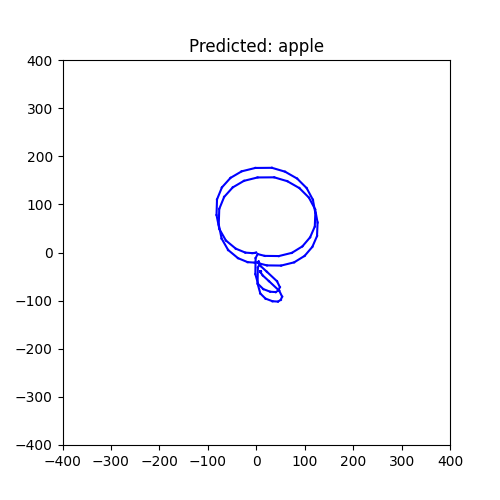

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Frame-wise breakdown of /content/output/apple_sketch.gif:
Frame 1:
  Predicted: No movement (pen up)
Frame 2:
  Predicted: Draws line with delta_x=-5.52, delta_y=-0.53
Frame 3:
  Predicted: Draws line with delta_x=-14.52, delta_y=1.05
Frame 4:
  Predicted: Draws line with delta_x=-19.80, delta_y=8.23
Frame 5:
  Predicted: Draws line with delta_x=-20.40, delta_y=16.97
Frame 6:
  Predicted: Draws line with delta_x=-13.59, delta_y=23.95
Frame 7:
  Predicted: Draws line with delta_x=-5.77, delta_y=29.02
Frame 8:
  Predicted: Draws line with delta_x=1.01, delta_y=32.35
Frame 9:
  Predicted: Draws line with delta_x=10.10, delta_y=24.96
Frame 10:
  Predicted: Draws line with delta_x=17.71, delta_y=19.79

Generating sample for: eye
Saved animation to /content/output/eye_sketch.gif
Saved final frame to /content/output/eye_sketch.png


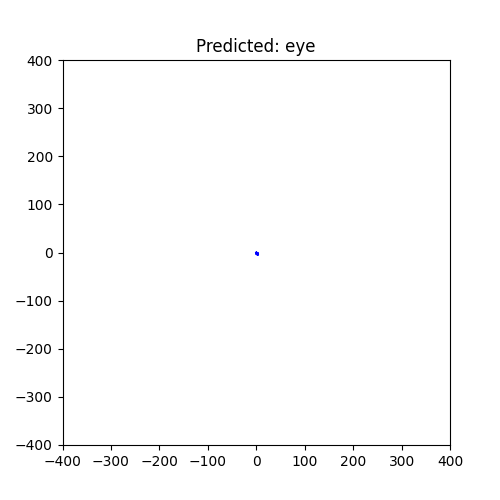

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Frame-wise breakdown of /content/output/eye_sketch.gif:
Frame 1:
  Predicted: Draws line with delta_x=0.55, delta_y=-0.90
Frame 2:
  Predicted: Draws line with delta_x=1.31, delta_y=-1.11
Frame 3:
  Predicted: Draws line with delta_x=0.09, delta_y=-0.14
Frame 4:
  Predicted: Draws line with delta_x=-0.02, delta_y=-0.01
Frame 5:
  Predicted: Draws line with delta_x=-0.02, delta_y=0.00
Frame 6:
  Predicted: Draws line with delta_x=-0.02, delta_y=0.01
Frame 7:
  Predicted: Draws line with delta_x=-0.02, delta_y=0.01
Frame 8:
  Predicted: Draws line with delta_x=-0.02, delta_y=0.01
Frame 9:
  Predicted: Draws line with delta_x=-0.02, delta_y=0.01
Frame 10:
  Predicted: Draws line with delta_x=-0.02, delta_y=0.01

Generating sample for: square
Saved animation to /content/output/square_sketch.gif
Saved final frame to /content/output/square_sketch.png


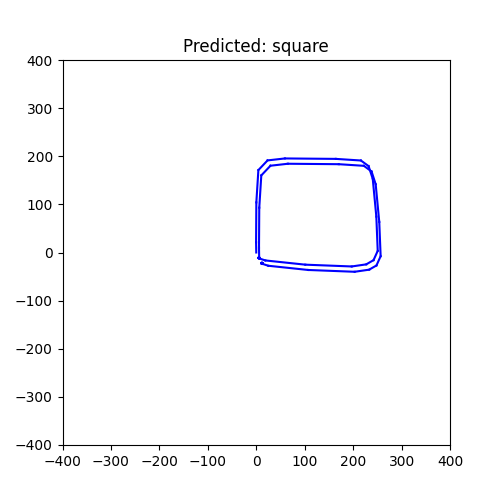

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Frame-wise breakdown of /content/output/square_sketch.gif:
Frame 1:
  Predicted: Draws line with delta_x=-0.34, delta_y=21.17
Frame 2:
  Predicted: Draws line with delta_x=0.52, delta_y=82.92
Frame 3:
  Predicted: Draws line with delta_x=4.21, delta_y=67.17
Frame 4:
  Predicted: Draws line with delta_x=18.96, delta_y=20.10
Frame 5:
  Predicted: Draws line with delta_x=35.85, delta_y=4.08
Frame 6:
  Predicted: Draws line with delta_x=105.12, delta_y=-0.92
Frame 7:
  Predicted: Draws line with delta_x=51.75, delta_y=-3.36
Frame 8:
  Predicted: Draws line with delta_x=15.91, delta_y=-11.70
Frame 9:
  Predicted: Draws line with delta_x=8.56, delta_y=-26.58
Frame 10:
  Predicted: Draws line with delta_x=7.37, delta_y=-78.30

Generating sample for: triangle
Saved animation to /content/output/triangle_sketch.gif
Saved final frame to /content/output/triangle_sketch.png


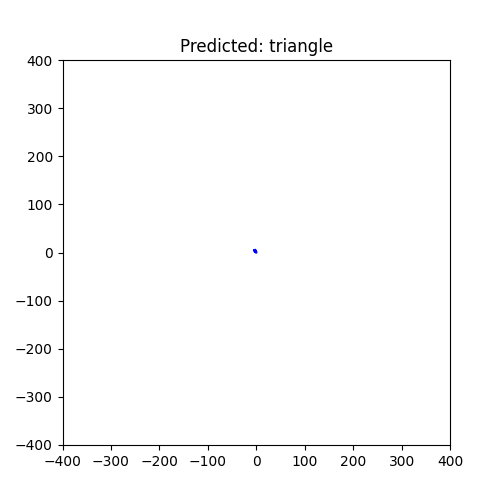

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Frame-wise breakdown of /content/output/triangle_sketch.gif:
Frame 1:
  Predicted: No movement (pen up)
Frame 2:
  Predicted: Draws line with delta_x=-0.56, delta_y=0.50
Frame 3:
  Predicted: Draws line with delta_x=-0.28, delta_y=-0.08
Frame 4:
  Predicted: Draws line with delta_x=-0.05, delta_y=0.03
Frame 5:
  Predicted: Draws line with delta_x=-0.02, delta_y=0.01
Frame 6:
  Predicted: Draws line with delta_x=-0.01, delta_y=0.00
Frame 7:
  Predicted: Draws line with delta_x=-0.01, delta_y=-0.00
Frame 8:
  Predicted: Draws line with delta_x=-0.02, delta_y=-0.00
Frame 9:
  Predicted: Draws line with delta_x=-0.02, delta_y=0.00
Frame 10:
  Predicted: Draws line with delta_x=-0.02, delta_y=0.00

Generating sample for: circle
Saved animation to /content/output/circle_sketch.gif
Saved final frame to /content/output/circle_sketch.png


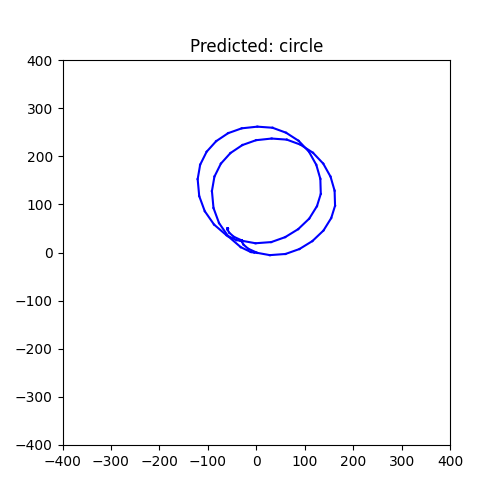

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Frame-wise breakdown of /content/output/circle_sketch.gif:
Frame 1:
  Predicted: No movement (pen up)
Frame 2:
  Predicted: Draws line with delta_x=-7.70, delta_y=1.37
Frame 3:
  Predicted: Draws line with delta_x=-20.55, delta_y=9.98
Frame 4:
  Predicted: Draws line with delta_x=-25.77, delta_y=22.35
Frame 5:
  Predicted: Draws line with delta_x=-19.18, delta_y=27.79
Frame 6:
  Predicted: Draws line with delta_x=-11.43, delta_y=31.38
Frame 7:
  Predicted: Draws line with delta_x=-3.23, delta_y=35.18
Frame 8:
  Predicted: Draws line with delta_x=5.15, delta_y=29.94
Frame 9:
  Predicted: Draws line with delta_x=13.33, delta_y=26.98
Frame 10:
  Predicted: Draws line with delta_x=19.67, delta_y=21.95


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os
import numpy as np
from IPython.display import display, HTML, Image
from google.colab import files

# Device configuration
device = torch.cuda.is_available() and torch.device("cuda") or torch.device("cpu")

# Hyperparameters
NUM_CLASSES = 5
HIDDEN_SIZE = 256
NUM_LAYERS = 3
EMBEDDING_DIM = 128
STROKE_DIM = 3
MAX_SEQ_LEN = 64
DROPOUT = 0.3
CLASSES = ["apple", "eye", "square", "triangle", "circle"]

# Model Definition
class SketchGenerator(nn.Module):
    def __init__(self, num_classes, embedding_dim, hidden_size, num_layers, stroke_dim):
        super(SketchGenerator, self).__init__()
        self.linear_in = nn.Linear(num_classes, embedding_dim)
        nn.init.xavier_uniform_(self.linear_in.weight)
        self.lstm = nn.LSTM(embedding_dim + stroke_dim, hidden_size, num_layers,
                          batch_first=True, dropout=DROPOUT)
        self.dropout = nn.Dropout(DROPOUT)
        self.fc = nn.Linear(hidden_size, stroke_dim)
        nn.init.xavier_uniform_(self.fc.weight)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, class_one_hot, strokes, hidden=None):
        batch_size = class_one_hot.size(0)
        seq_len = strokes.size(1) if strokes is not None else MAX_SEQ_LEN
        class_embed = self.linear_in(class_one_hot).unsqueeze(1).repeat(1, seq_len, 1)
        inputs = torch.cat((class_embed, strokes), dim=2) if strokes is not None else class_embed
        if hidden is None:
            hidden = (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device),
                     torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device))
        out, hidden = self.lstm(inputs, hidden)
        out = self.dropout(out)
        out = self.fc(out)
        return out, hidden

# Visualization function
def visualize_sketch(model, class_one_hot, class_name, weights_path, save_path="/content/output"):
    model.eval()
    os.makedirs(save_path, exist_ok=True)

    # Load weights
    model.load_state_dict(torch.load(weights_path, map_location=device))

    with torch.no_grad():
        strokes = torch.zeros(1, 1, STROKE_DIM).to(device)
        hidden = None
        generated_strokes = []
        for _ in range(MAX_SEQ_LEN):
            output, hidden = model(class_one_hot.to(device), strokes, hidden)
            strokes = output[:, -1:, :]
            generated_strokes.append(strokes.cpu().numpy()[0, 0])

    # Helper function to initialize plots
    def init_plot(ax, title):
        ax.clear()
        ax.set_title(title)
        ax.invert_yaxis()
        ax.set_xlim(-400, 400)
        ax.set_ylim(-400, 400)
        return []

    # Animation function
    fig, ax = plt.subplots(figsize=(5, 5))
    pred_lines = []

    def init():
        return init_plot(ax, f"Predicted: {class_name}")

    def update(frame):
        nonlocal pred_lines
        if frame < len(generated_strokes):
            delta_x, delta_y, pen_state = generated_strokes[frame]
            if pen_state != 0:
                x = pred_lines[-1].get_xdata()[-1] if pred_lines else 0
                y = pred_lines[-1].get_ydata()[-1] if pred_lines else 0
                new_x, new_y = x + delta_x, y + delta_y
                line, = ax.plot([x, new_x], [y, new_y], 'b-')
                pred_lines.append(line)
        return pred_lines

    ani = FuncAnimation(fig, update, frames=len(generated_strokes),
                       init_func=init, blit=False, interval=100, repeat=False)
    gif_path = f"{save_path}/{class_name}_sketch.gif"
    png_path = f"{save_path}/{class_name}_sketch.png"

    # Save GIF
    ani.save(gif_path, writer='pillow', fps=10)

    # Save final frame as PNG
    for frame in range(len(generated_strokes)):
        update(frame)
    plt.savefig(png_path)
    plt.close()

    print(f"Saved animation to {gif_path}")
    print(f"Saved final frame to {png_path}")

    # Display in Colab
    display(HTML(f'<img src="{gif_path}" />'))
    display(Image(filename=png_path))

    # Download files
    files.download(gif_path)
    files.download(png_path)

    # Frame-wise description
    print(f"\nFrame-wise breakdown of {gif_path}:")
    for i in range(min(10, len(generated_strokes))):
        pred_desc = "No movement (pen up)"
        delta_x, delta_y, pen = generated_strokes[i]
        if pen > 0:
            pred_desc = f"Draws line with delta_x={delta_x:.2f}, delta_y={delta_y:.2f}"
        print(f"Frame {i+1}:")
        print(f"  Predicted: {pred_desc}")

# Main function to reproduce sketches
def reproduce_sketches(weights_path="/content/sketch_generator.pth"):
    model = SketchGenerator(NUM_CLASSES, EMBEDDING_DIM, HIDDEN_SIZE, NUM_LAYERS, STROKE_DIM).to(device)

    for class_name in CLASSES:
        class_idx = CLASSES.index(class_name)
        class_one_hot = torch.zeros(1, NUM_CLASSES)
        class_one_hot[0, class_idx] = 1.0
        print(f"\nGenerating sample for: {class_name}")
        visualize_sketch(model, class_one_hot, class_name, weights_path)

if __name__ == "__main__":
    weights_path = "/content/sketch_generator_best.pth"  # Update this path if needed
    reproduce_sketches(weights_path)